In [1]:
import pandas as pd
import numpy as np

In [2]:
# Load the training dataset
train_csv_path = './archive/sign_mnist_train.csv'
train_data = pd.read_csv(train_csv_path)

# Load the testing dataset
test_csv_path = './archive/sign_mnist_test.csv'
test_data = pd.read_csv(test_csv_path)

In [3]:
import pandas as pd
import numpy as np

class CustomLogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000, num_classes=None):
        """
        Initialize the Logistic Regression model
        
        Parameters:
        - learning_rate: step size for gradient descent
        - num_iterations: number of training iterations
        - num_classes: number of unique classes in the dataset
        """
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.num_classes = num_classes
        self.weights = None
        self.bias = None
        self.class_mapping = None  # To handle zero-based indexing

    def _softmax(self, z):
        """
        Softmax activation function for multiclass classification
        Prevents numerical instability by subtracting max value
        
        Parameters:
        - z: input array of logits
        
        Returns:
        - Softmax probabilities
        """
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def _one_hot_encode(self, y):
        """
        Convert labels to one-hot encoded format
        
        Parameters:
        - y: original labels
        
        Returns:
        - One-hot encoded labels
        """
        # Remap labels to zero-based index if needed
        if self.class_mapping is None:
            unique_classes = np.unique(y)
            self.class_mapping = {orig: idx for idx, orig in enumerate(unique_classes)}
            self.reverse_mapping = {idx: orig for orig, idx in self.class_mapping.items()}
        
        # Map original labels to zero-based index
        y_mapped = np.array([self.class_mapping[label] for label in y])
        
        # Create one-hot encoding
        one_hot = np.zeros((y.shape[0], self.num_classes))
        one_hot[np.arange(y.shape[0]), y_mapped] = 1
        return one_hot

    def fit(self, X, y):
        """
        Train the logistic regression model
        
        Parameters:
        - X: input features (num_samples, num_features)
        - y: target labels
        """
        # Determine number of classes if not specified
        unique_classes = np.unique(y)
        self.num_classes = len(unique_classes)
        
        # Initialize weights and bias
        num_features = X.shape[1]
        self.weights = np.zeros((num_features, self.num_classes))
        self.bias = np.zeros((1, self.num_classes))
        
        # One-hot encode labels
        Y_one_hot = self._one_hot_encode(y)
        
        # Gradient descent
        for _ in range(self.num_iterations):
            # Forward pass
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self._softmax(linear_model)
            
            # Compute gradients
            dw = (1/X.shape[0]) * np.dot(X.T, (y_predicted - Y_one_hot))
            db = (1/X.shape[0]) * np.sum(y_predicted - Y_one_hot, axis=0, keepdims=True)
            
            # Update parameters
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        """
        Make predictions on input data
        
        Parameters:
        - X: input features
        
        Returns:
        - Predicted class labels (original class labels)
        """
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self._softmax(linear_model)
        
        # Get indices of max probabilities
        predicted_indices = np.argmax(y_predicted, axis=1)
        
        # Map back to original class labels
        return np.array([self.reverse_mapping[idx] for idx in predicted_indices])

    def predict_proba(self, X):
        """
        Predict class probabilities
        
        Parameters:
        - X: input features
        
        Returns:
        - Predicted class probabilities
        """
        linear_model = np.dot(X, self.weights) + self.bias
        return self._softmax(linear_model)

    def accuracy(self, X, y):
        """
        Compute model accuracy
        
        Parameters:
        - X: input features
        - y: true labels
        
        Returns:
        - Accuracy score
        """
        predictions = self.predict(X)
        return np.mean(predictions == y)

def preprocess_sign_mnist(train_data, test_data):
    """
    Preprocess Sign MNIST dataset
    
    Parameters:
    - train_data: Training dataframe
    - test_data: Testing dataframe
    
    Returns:
    - Preprocessed X_train, X_test, y_train, y_test
    """
    # Separate features and labels
    X_train = train_data.drop('label', axis=1).values
    y_train = train_data['label'].values
    
    X_test = test_data.drop('label', axis=1).values
    y_test = test_data['label'].values
    
    # Normalize pixel values to [0, 1]
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    
    print("Unique training classes:", np.unique(y_train))
    print("Unique testing classes:", np.unique(y_test))
    
    return X_train, X_test, y_train, y_test

def train_logistic_regression(X_train, X_test, y_train, y_test):
    """
    Train custom Logistic Regression on Sign MNIST
    
    Parameters:
    - X_train: Training features
    - X_test: Testing features
    - y_train: Training labels
    - y_test: Testing labels
    
    Returns:
    - Trained model
    - Training and test accuracies
    """
    # Create and train the model
    clf = CustomLogisticRegression(
        learning_rate=0.1,  # You can tune this
        num_iterations=1000,  # You can increase for better convergence
        num_classes=len(np.unique(y_train))
    )
    
    # Fit the model
    clf.fit(X_train, y_train)
    
    # Compute accuracies
    train_accuracy = clf.accuracy(X_train, y_train)
    test_accuracy = clf.accuracy(X_test, y_test)
    
    return clf, train_accuracy, test_accuracy

# Main execution
def main():
    # Load the training dataset
    train_csv_path = './archive/sign_mnist_train.csv'
    train_data = pd.read_csv(train_csv_path)
    
    # Load the testing dataset
    test_csv_path = './archive/sign_mnist_test.csv'
    test_data = pd.read_csv(test_csv_path)
    
    # Preprocess the data
    X_train, X_test, y_train, y_test = preprocess_sign_mnist(train_data, test_data)
    
    # Train the model
    model, train_acc, test_acc = train_logistic_regression(X_train, X_test, y_train, y_test)
    
    # Print results
    print(f"Training Accuracy: {train_acc * 100:.2f}%")
    print(f"Testing Accuracy: {test_acc * 100:.2f}%")
    
    return model, X_test, y_test

# Optional: Confusion Matrix and Classification Report
def evaluate_model(model, X_test, y_test):
    """
    Generate detailed model evaluation
    
    Parameters:
    - model: Trained logistic regression model
    - X_test: Test features
    - y_test: Test labels
    """
    # Predictions
    y_pred = model.predict(X_test)
    
    # Confusion Matrix
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

# Run the main function
if __name__ == "__main__":
    model, X_test, y_test = main()
    evaluate_model(model, X_test, y_test)

Unique training classes: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Unique testing classes: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Training Accuracy: 76.39%
Testing Accuracy: 63.43%
Confusion Matrix:
[[323   0   0   0   0   0   0   0   0   0   0   0   3   4   0   0   0   1
    0   0   0   0   0   0]
 [  0 349   0   0   0   0   0   0   0  75   0   0   0   0   0   0   0   0
    0   0   0   8   0   0]
 [  0   0 264   0   0  16   0   0   0   0   5   0   0  19   0   0   0   0
    0   0   0   0   6   0]
 [  0   0   0 153   0   0   0   0   0  15   0   0  14   0   0   0   0   5
    0   0   6   0  52   0]
 [  0   0   0   0 435   0   0   0   0   0   0   0   0   0   0   0   0  63
    0   0   0   0   0   0]
 [  0   0  20   0   0 201   0   0   0   0   1   0   0   5   0   0   0   0
    0   0   0  20   0   0]
 [  0   0   0  20   0   0 203  18   0   0   0   0  21  14   0  19   0   0
   52   0   0   0   1   0]
 [  0   0   0   0  16   0  

In [4]:
def preprocess_sign_mnist(train_data, test_data):
    # Separate features and labels
    X_train = train_data.drop('label', axis=1).values
    y_train = train_data['label'].values
    
    X_test = test_data.drop('label', axis=1).values
    y_test = test_data['label'].values
    
    # Normalize pixel values to [0, 1]
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    
    print("Unique training classes:", np.unique(y_train))
    print("Unique testing classes:", np.unique(y_test))
    
    return X_train, X_test, y_train, y_test

In [5]:
# Preprocess the data
X_train, X_test, y_train, y_test = preprocess_sign_mnist(train_data, test_data)

Unique training classes: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Unique testing classes: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


In [6]:
# Create and train the model
clf = CustomLogisticRegression(
    learning_rate=0.1,  # You can tune this
    num_iterations=1000,  # You can increase for better convergence
    num_classes=len(np.unique(y_train))
)

# Fit the model
clf.fit(X_train, y_train)

In [7]:
# Compute accuracies
train_accuracy = clf.accuracy(X_train, y_train)
test_accuracy = clf.accuracy(X_test, y_test)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

Training Accuracy: 76.39%
Testing Accuracy: 63.43%


In [8]:
# Predictions
y_pred = clf.predict(X_test)

# Import sklearn metrics
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[323   0   0   0   0   0   0   0   0   0   0   0   3   4   0   0   0   1
    0   0   0   0   0   0]
 [  0 349   0   0   0   0   0   0   0  75   0   0   0   0   0   0   0   0
    0   0   0   8   0   0]
 [  0   0 264   0   0  16   0   0   0   0   5   0   0  19   0   0   0   0
    0   0   0   0   6   0]
 [  0   0   0 153   0   0   0   0   0  15   0   0  14   0   0   0   0   5
    0   0   6   0  52   0]
 [  0   0   0   0 435   0   0   0   0   0   0   0   0   0   0   0   0  63
    0   0   0   0   0   0]
 [  0   0  20   0   0 201   0   0   0   0   1   0   0   5   0   0   0   0
    0   0   0  20   0   0]
 [  0   0   0  20   0   0 203  18   0   0   0   0  21  14   0  19   0   0
   52   0   0   0   1   0]
 [  0   0   0   0  16   0  45 348   0   0   0   0   0   0   0   0   0   0
   22   0   0   0   5   0]
 [  3   0   0   0   0   0   0   0 190   0   0   0  21   0   0  12   0  21
    0   0   0   0   0  41]
 [  0   0   0   9   0  21   0   0  24 159   0   0   0   0   0   0  87   3

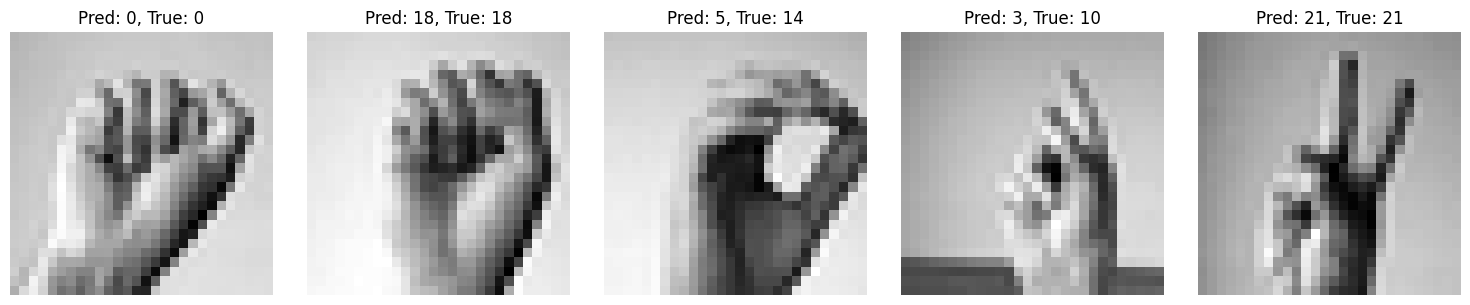

In [9]:
# Visualize some predictions
import matplotlib.pyplot as plt

# Select a few random test samples
num_samples_to_show = 5
indices = np.random.randint(0, X_test.shape[0], num_samples_to_show)

plt.figure(figsize=(15, 3))
for i, idx in enumerate(indices):
    plt.subplot(1, num_samples_to_show, i+1)
    plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f"Pred: {y_pred[idx]}, True: {y_test[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [10]:
from sklearn.model_selection import StratifiedKFold
from itertools import product

class LogisticRegressionTuner:
    def __init__(self, X_train, X_test, y_train, y_test):
        """
        Initialize tuner with training and testing data
        
        Parameters:
        - X_train: Training features
        - X_test: Testing features
        - y_train: Training labels
        - y_test: Testing labels
        """
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
    
    def cross_validate(self, learning_rate, num_iterations, n_splits=5):
        """
        Perform cross-validation
        
        Parameters:
        - learning_rate: Learning rate to test
        - num_iterations: Number of iterations
        - n_splits: Number of cross-validation splits
        
        Returns:
        - Average cross-validation accuracy
        """
        # Stratified K-Fold for maintaining class distribution
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        cv_scores = []
        
        for train_index, val_index in skf.split(self.X_train, self.y_train):
            # Split data
            X_train_cv = self.X_train[train_index]
            y_train_cv = self.y_train[train_index]
            X_val_cv = self.X_train[val_index]
            y_val_cv = self.y_train[val_index]
            
            # Train model
            clf = CustomLogisticRegression(
                learning_rate=learning_rate, 
                num_iterations=num_iterations,
                num_classes=len(np.unique(y_train_cv))
            )
            clf.fit(X_train_cv, y_train_cv)
            
            # Compute accuracy
            cv_accuracy = clf.accuracy(X_val_cv, y_val_cv)
            cv_scores.append(cv_accuracy)
        
        return np.mean(cv_scores)
    
    def grid_search(self):
        """
        Perform grid search for hyperparameters
        
        Returns:
        - Best hyperparameters and their performance
        """
        # Hyperparameter grid
        learning_rates = [0.001, 0.01, 0.1, 0.5, 1.0]
        iterations_list = [500, 1000, 1500, 2000]
        
        # Store results
        results = []
        
        # Grid search
        for lr, iterations in product(learning_rates, iterations_list):
            # Cross-validation
            cv_accuracy = self.cross_validate(lr, iterations)
            
            # Final model evaluation on test set
            clf = CustomLogisticRegression(
                learning_rate=lr, 
                num_iterations=iterations,
                num_classes=len(np.unique(self.y_train))
            )
            clf.fit(self.X_train, self.y_train)
            test_accuracy = clf.accuracy(self.X_test, self.y_test)
            
            # Store results
            results.append({
                'learning_rate': lr,
                'iterations': iterations,
                'cv_accuracy': cv_accuracy,
                'test_accuracy': test_accuracy
            })
            
            print(f"LR: {lr}, Iterations: {iterations}")
            print(f"CV Accuracy: {cv_accuracy * 100:.2f}%")
            print(f"Test Accuracy: {test_accuracy * 100:.2f}%\n")
        
        # Find best parameters
        results_df = pd.DataFrame(results)
        best_cv_row = results_df.loc[results_df['cv_accuracy'].idxmax()]
        best_test_row = results_df.loc[results_df['test_accuracy'].idxmax()]
        
        print("Best by Cross-Validation:")
        print(best_cv_row)
        print("\nBest by Test Accuracy:")
        print(best_test_row)
        
        return results_df, best_cv_row, best_test_row
    
    def feature_importance(self):
        """
        Analyze feature importance
        
        Returns:
        - Feature importance scores
        """
        # Train final model
        clf = CustomLogisticRegression(
            learning_rate=0.1, 
            num_iterations=1000,
            num_classes=len(np.unique(self.y_train))
        )
        clf.fit(self.X_train, self.y_train)
        
        # Compute feature importance based on absolute weight magnitudes
        feature_importances = np.abs(clf.weights).mean(axis=1)
        
        # Sort features by importance
        sorted_indices = np.argsort(feature_importances)[::-1]
        
        # Visualize top 10 most important features
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=(10, 6))
        plt.title("Top 10 Most Important Features")
        plt.bar(range(10), feature_importances[sorted_indices[:10]])
        plt.xlabel("Feature Index")
        plt.ylabel("Importance Score")
        plt.show()
        
        return feature_importances, sorted_indices

# Additional utility function for dimensionality reduction
def apply_pca(X_train, X_test, n_components=50):
    """
    Apply PCA for dimensionality reduction
    
    Parameters:
    - X_train: Training features
    - X_test: Testing features
    - n_components: Number of components to keep
    
    Returns:
    - Reduced X_train, X_test
    """
    from sklearn.decomposition import PCA
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Explained variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    
    # Visualize explained variance
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-')
    plt.title('Cumulative Explained Variance')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.show()
    
    return X_train_pca, X_test_pca

# Main execution function
def hyperparameter_tuning(X_train, X_test, y_train, y_test):
    """
    Comprehensive hyperparameter tuning pipeline
    
    Parameters:
    - X_train: Training features
    - X_test: Testing features
    - y_train: Training labels
    - y_test: Testing labels
    
    Returns:
    - Tuning results
    """
    # Tuning with original features
    tuner = LogisticRegressionTuner(X_train, X_test, y_train, y_test)
    
    # Perform grid search
    results_df, best_cv, best_test = tuner.grid_search()
    
    # Analyze feature importance
    feature_importances, sorted_indices = tuner.feature_importance()
    
    # Optional: Apply PCA and retune
    X_train_pca, X_test_pca = apply_pca(X_train, X_test)
    
    # Tuning with PCA-reduced features
    pca_tuner = LogisticRegressionTuner(X_train_pca, X_test_pca, y_train, y_test)
    pca_results_df, pca_best_cv, pca_best_test = pca_tuner.grid_search()
    
    return {
        'original_results': results_df,
        'best_cv': best_cv,
        'best_test': best_test,
        'pca_results': pca_results_df,
        'pca_best_cv': pca_best_cv,
        'pca_best_test': pca_best_test
    }

# Example usage
# results = hyperparameter_tuning(X_train, X_test, y_train, y_test)

In [ ]:
# After preprocessing your data
results = hyperparameter_tuning(X_train, X_test, y_train, y_test)

LR: 0.001, Iterations: 500
CV Accuracy: 18.01%
Test Accuracy: 11.73%

